# Tugas 4 (PageRank dan Ringkasan Text)

## Graph ber arah(Vector Graph)

In [109]:
import networkx as nx
import matplotlib.pyplot as plt

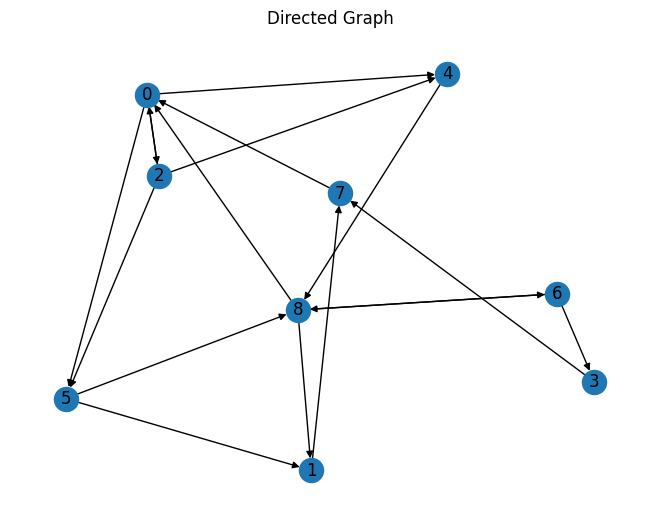

In [110]:
# Membuat directed graph
G2 = nx.DiGraph()

G2.add_edges_from([(0, 2), (0, 4), (0, 5), (1, 7), (2, 0), (2, 4), (2, 5), (3, 7), (4, 8), (5, 1), (5, 8), (6,3), (6, 8), (7, 0), (8, 0), (8, 1), (8, 6)])

# Menampilkan graph
nx.draw(G2, with_labels=True)
plt.title('Directed Graph')
plt.show()

### PageRank

<!-- formula 1 pagerank -->
$$PR(A) = \frac{1}{N} + d \sum_{B \in In(A)} \frac{PR(B)}{Out(B)}$$ 

<!-- explain pagerank formula -->
$PR(A)$ adalah pagerank dari node A

$N$ adalah jumlah node

$d$ adalah damping factor

$In(A)$ adalah node yang menunjuk ke node A

$PR(B)$ adalah pagerank dari node B yang menunjuk ke node A

$Out(B)$ adalah jumlah node keluar dari node B

#### PageRank NetworkX

In [111]:
# pagerank
pagerank=nx.pagerank(G2, alpha=0.85)
print(sum(pagerank.values()))

sorted(pagerank.items(), key=lambda x: x[0])

0.9999999999999999


[(0, 0.20729395202262893),
 (1, 0.10518371414099925),
 (2, 0.0753996874851362),
 (3, 0.04389153135085262),
 (4, 0.09676309522313073),
 (5, 0.09676309522313073),
 (6, 0.06405897670360203),
 (7, 0.14338020418747494),
 (8, 0.16726574366304436)]

#### PageRank Manual

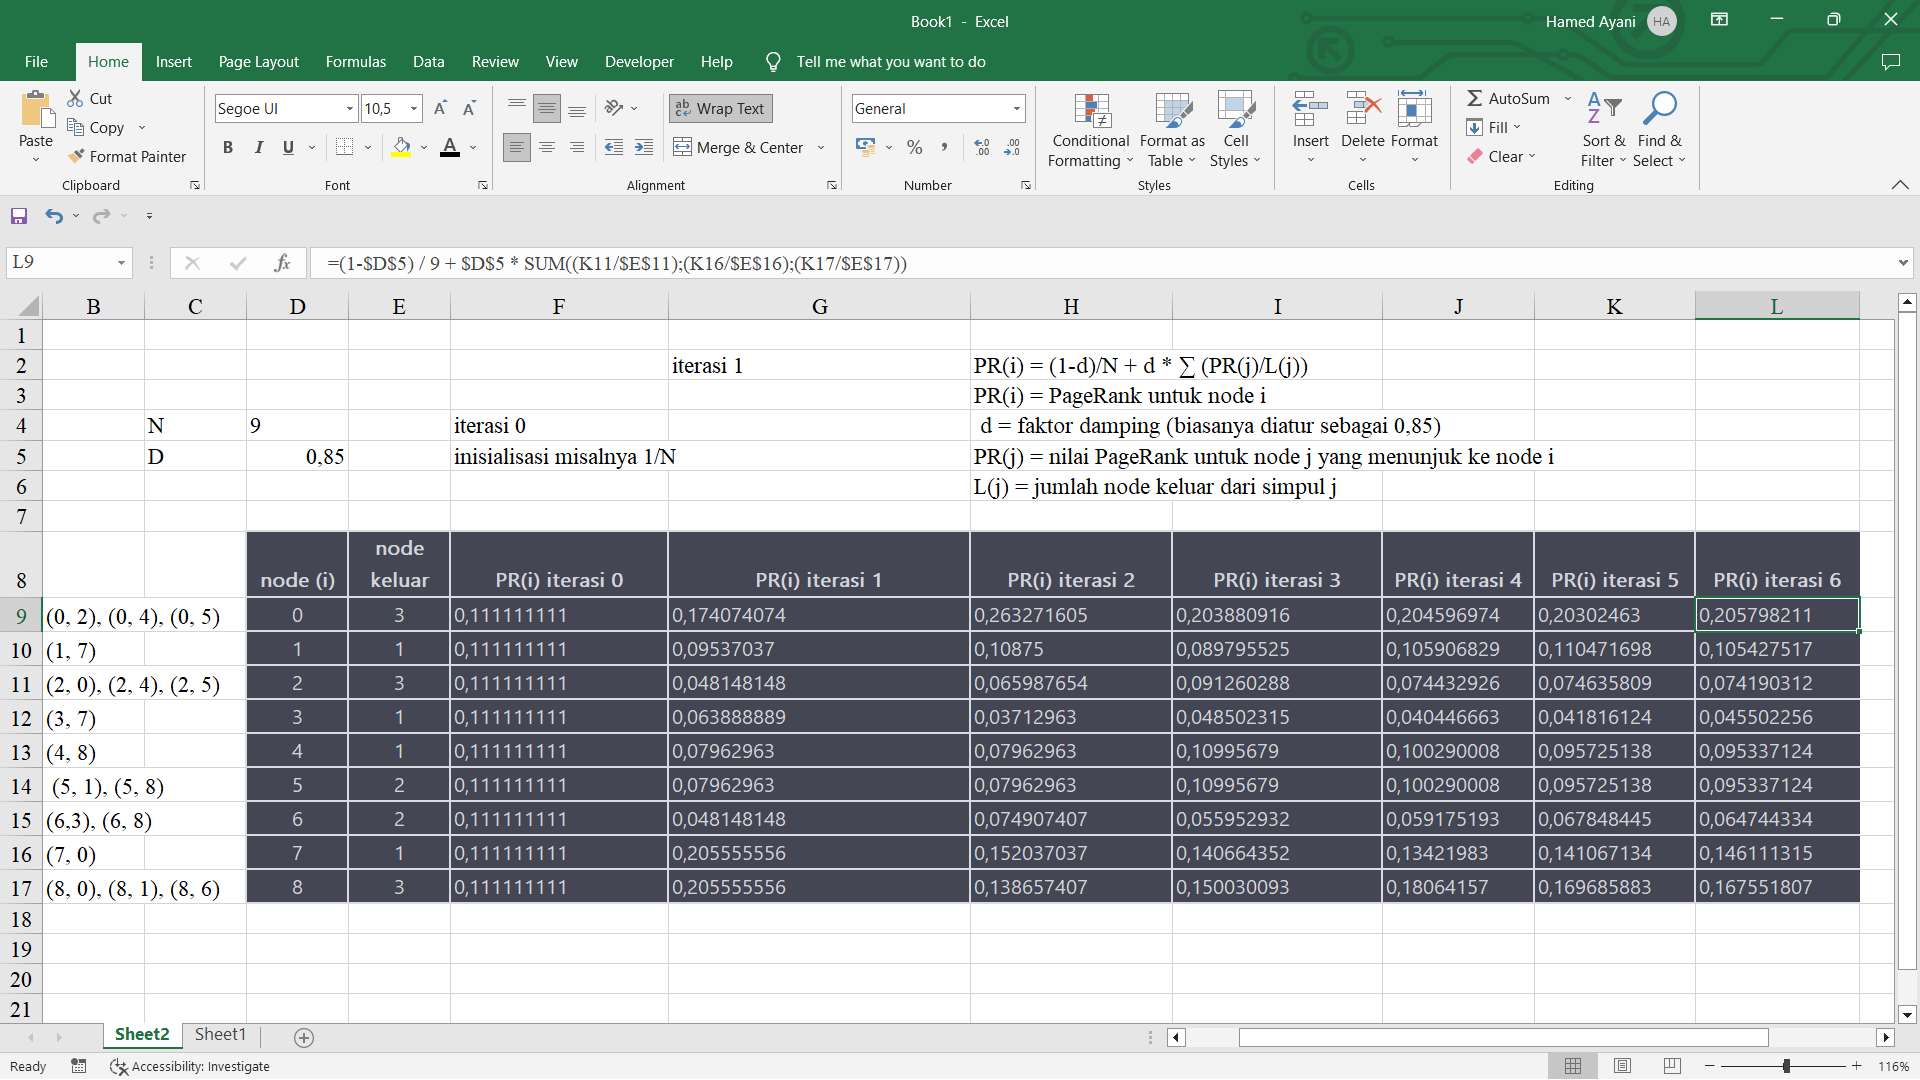

#### Hasil perbandingan


Penghitungan pagerank dari library networkX dan penghitungan manual dengan excel dengan 6 iterasi sudah mendekati(mirip).

## Text Summarizion

### Algoritma ringkasan teks

Dalam ringkasan teks terdapat beberapa langkah yang harus dilakukan;


1.   Read text dan pembersihan teks
2.   Bangun Matrik similarity dari kalimat
>dengan mengukur tingkat kesamaan antara dua kalimat. Fungsi ini menggunakan pendekatan cosine similarity untuk menghitung similarity antara dua vektor kalimat. Vektor kalimat dihitung dengan menghitung frekuensi kemunculan setiap kata pada kalimat tersebut. Setelah itu bangun matrix similarity yang menghasilkan matriks similarity antara semua pasang kalimat yang terdapat pada dokumen teks. Matriks ini digunakan untuk merepresentasikan hubungan antar kalimat dalam bentuk graf.

3.   RankSentences dari matrix similarity

4.   Ambil RankSentences tertinggi untuk digunakan ringkasan teks
>Ringkasan teks dihasilkan dengan melakukan pengurutan kalimat-kalimat pada dokumen teks berdasarkan nilai PageRank pada graf similarity antar kalimat. Kalimat-kalimat dengan nilai PageRank yang tinggi dianggap lebih penting dan dipilih sebagai bagian dari ringkasan teks.

Berikut adalah penjelasan algoritma untuk membuat laporan:

1. Membaca dokumen.
2. Split dokumen menjadi kalimat (tokenisasi kalimat).
3. Menghitung skor setiap kalimat dengan menghitung frekuensi kata-kata yang muncul dalam kalimat menggunakan algoritma PageRank.
>Setiap kalimat dikonversi menjadi vektor dengan menghitung frekuensi kemunculan kata-kata pada kalimat tersebut menggunakan CountVectorizer, dan kata yang termasuk stopwords tidak ikut dihitung. 
<br> Setelah itu, vektor-vektor kalimat tersebut dinormalisasi menggunakan TfidfTransformer sehingga hasilnya adalah matriks normalisasi. Matriks normalisasi tersebut dikalikan dengan transposenya (matriks dot product) sehingga menghasilkan res_graph yang merepresentasikan similarity score antara masing-masing kalimat pada dokumen
4. res_graph diubah menjadi graph networkx.
> Dari Graph yang dibentuk tentukan nilai PageRank dari kalimat graph(node mewakili kalimat). Urutkan kalimat dengan pagerank tertinggi.
4. Memilih kalimat-kalimat yang akan dimasukkan ke dalam ringkasan berdasarkan nilai pagerank.
> Pemilihan kalimat didasarkan pada skor pagerank yaitu dengan memberi threshold(rata-rata pagerank kalimat) dan menentukan berapa banyak kalimat yang akan digunakan sebagai ringkasan. Kalimat-kalimat yang dipilih adalah kalimat yang memiliki skor di atas ambang batas dan kurang dari max kalimat ringkasan.
5. Menghasilkan ringkasan dari kalimat-kalimat yang dipilih dengan cara menggabungkan kalimat-kalimat tersebut.
6. Menyimpan ringkasan ke dalam sebuah dokumen baru sebagai laporan.

### Code

In [112]:
!pip install PyPDF2 docx2txt --quiet

In [113]:
import nltk
nltk.download('popular', quiet=True)

True

In [114]:
from nltk.corpus import stopwords
import PyPDF2
import docx2txt
import sys
from nltk.tokenize.punkt import PunktSentenceTokenizer
import networkx as nx
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [128]:
def readDoc(name):
    if name.lower().endswith('.txt'):
        f = open(name, 'r', encoding="utf8")
        document = f.read()
        f.close()
    elif name.lower().endswith('.docx') or name.lower().endswith('.doc'):
        document = docx2txt.process(name)

    elif name.lower().endswith('.pdf'):
        document = ''
        pdfReader = PyPDF2.PdfReader(name)

        num_pages = len(pdfReader.pages)
        for i in range(num_pages):
            pageObj = pdfReader.pages[i]
            document += pageObj.extract_text()
    else:
        sys.exit("File tidak didukung, hanya .txt, .docx, .doc, .pdf")

    document_clean = document.replace('\n', ' ').replace('  ', ' ').replace(' -', '-').replace('- ', '-').replace(' .', '.')
    # print(type(document))
    return document_clean

def tokenize(document):
    doc_tokenizer = PunktSentenceTokenizer()
    sentences_list = doc_tokenizer.tokenize(document)
    return sentences_list

def pagerankKalimat(sentences_list):
    stopwords_ind = stopwords.words('indonesian')
    listsw=['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya']
    stopwords_ind.extend(listsw)
    cv = CountVectorizer(stop_words=stopwords_ind)
    cv_matrix = cv.fit_transform(sentences_list)

    normal_matrix = TfidfTransformer().fit_transform(cv_matrix)
    res_graph = normal_matrix * normal_matrix.T

    nx_graph = nx.from_scipy_sparse_array(res_graph)
    ranks = nx.pagerank(nx_graph)
    # print(sum(ranks.values()))

    sentence_array = sorted(
        ((ranks[i], s) for i, s in enumerate(sentences_list)), reverse=True)
    return sentence_array

def gabungKalimat(sentence_array, n_kalimat):
    if n_kalimat is None:
       n_kalimat = len(sentence_array)
       
    rank_sum = sum(score for score, _ in sentence_array)
    threshold = rank_sum / len(sentence_array)
    
    sentence_list = []
    for score, sentence in sentence_array:
        if score >= threshold and len(sentence_list) < n_kalimat:
            sentence_list.append(sentence)
    
    summary = " ".join(sentence_list)
    return summary

def ringkasanTeks(filename, n_kalimat=None):
    document = readDoc(filename)
    kalimat_token = tokenize(document)
    pagerank_kalimat = pagerankKalimat(kalimat_token)
    summary = gabungKalimat(pagerank_kalimat, n_kalimat)
    return summary


#### Implementasi file txt

In [116]:
!wget https://raw.githubusercontent.com/HamedAyani114/dataset/main/teks/berita1.txt

--2023-04-20 12:44:30--  https://raw.githubusercontent.com/HamedAyani114/dataset/main/teks/berita1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3808 (3.7K) [text/plain]
Saving to: ‘berita1.txt.1’

berita1.txt.1       100%[===================>]   3.72K  --.-KB/s    in 0s      

2023-04-20 12:44:30 (45.0 MB/s) - ‘berita1.txt.1’ saved [3808/3808]



In [126]:
outSummary_berita1=ringkasanTeks("berita1.txt",15)
print(len(outSummary_berita1.split('. ')))
outSummary_berita1


9


'Kronologi OTT Wali Kota Yana Mulyana Dkk Terkait Suap Rp 924,6 Juta untuk Bandung Smart City Modus THR sebagai gratifikasi atau suap terhadap pejabat negara juga terjadi dalam pelaksanaan OTT beberapa waktu lalu. KPK Amankan Uang Asing hingga Sepatu Louis Vuitton Saat OTT Wali Kota Bandung Yana MulyanaYana diduga menerima suap dalam proyek pengadaan closed circuit television (CCTV) dan internet service provider (ISP) untuk layanan digital Bandung Smart City di Pemerintah Kota Bandung, Jawa Barat tahun anggaran 2022-2023. Terkini, modus THR terungkap dalam operasi tangkap tangan (OTT) terhadap Wali Kota Bandung Yana Mulyana pada Jumat (15/4/2023). Sebelum Ditangkap KPK, Yana Mulyana Lantik Pejabat Pemkot hingga Resmikan Kampung Bebas RentenirKeenamnya diduga melakukan tindak pidana suap terkait pengadaan CCTV dan jasa jaringan internet program Bandung Smart City Tahun Anggaran 2022-2023. "Modus korupsi untuk pemberian THR juga menjadi perhatian kami setelah pada tangkap tangan KPK sebe

In [127]:
outSummary_berita1=ringkasanTeks("berita1.txt",5)
print(len(outSummary_berita1.split('. ')))
outSummary_berita1


5


'Kronologi OTT Wali Kota Yana Mulyana Dkk Terkait Suap Rp 924,6 Juta untuk Bandung Smart City Modus THR sebagai gratifikasi atau suap terhadap pejabat negara juga terjadi dalam pelaksanaan OTT beberapa waktu lalu. KPK Amankan Uang Asing hingga Sepatu Louis Vuitton Saat OTT Wali Kota Bandung Yana MulyanaYana diduga menerima suap dalam proyek pengadaan closed circuit television (CCTV) dan internet service provider (ISP) untuk layanan digital Bandung Smart City di Pemerintah Kota Bandung, Jawa Barat tahun anggaran 2022-2023. Terkini, modus THR terungkap dalam operasi tangkap tangan (OTT) terhadap Wali Kota Bandung Yana Mulyana pada Jumat (15/4/2023). Sebelum Ditangkap KPK, Yana Mulyana Lantik Pejabat Pemkot hingga Resmikan Kampung Bebas RentenirKeenamnya diduga melakukan tindak pidana suap terkait pengadaan CCTV dan jasa jaringan internet program Bandung Smart City Tahun Anggaran 2022-2023. "Modus korupsi untuk pemberian THR juga menjadi perhatian kami setelah pada tangkap tangan KPK sebe

#### implementasi file PDF

In [119]:
!wget https://raw.githubusercontent.com/HamedAyani114/dataset/main/teks/rangkuman.pdf 

--2023-04-20 12:44:31--  https://raw.githubusercontent.com/HamedAyani114/dataset/main/teks/rangkuman.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86475 (84K) [application/octet-stream]
Saving to: ‘rangkuman.pdf.1’

rangkuman.pdf.1     100%[===================>]  84.45K  --.-KB/s    in 0.003s  

2023-04-20 12:44:31 (32.0 MB/s) - ‘rangkuman.pdf.1’ saved [86475/86475]



In [131]:
outSummary_rangkuman=ringkasanTeks('rangkuman.pdf',20)
print(len(outSummary_rangkuman.split('. ')))
outSummary_rangkuman

21


'Dan setiap kalimat akan diberi skor berdasarkan pentingnya  dalam teks inpu t. Sistem extractive memilih beberapa kalimat terbaik untuk dijadikan ringkasan  Terdapat beberapa yang mempengaruhi penilaian pentingnya suatu kalimat dalam teks, seperti konteks pengguna atau query, lingkungan tempat dokumen input berada, dan genre dokumen. Pendekatan ini dapat digunakan untuk memilih kalimat atau kata-kata yang penting dalam dokumen dan membuat ringkasan yang efektif. Bobot yang diberikan pada setiap kalimat dihitung berdasarkan probabilitas rata-rata kata dalam kalimat tersebut, d an memilih kalimat skor terbaik. Terdapat tiga proses utama , yaitu menciptakan representasi intermediat dari teks input, memberikan skor pada setiap kalimat berdasarkan representasi tersebut, dan memilih beberapa kalimat terbaik sebagai ringkasan. Dalam web summarization, konteks dapat digunakan untuk menentukan kalimat-kalimat penting yang akan disederhanakan. Pendekatan ini menciptakan representasi teks yang d

In [129]:
outSummary_rangkuman=ringkasanTeks('rangkuman.pdf')
print(len(outSummary_rangkuman.split('. ')))
outSummary_rangkuman

59


'Dan setiap kalimat akan diberi skor berdasarkan pentingnya  dalam teks inpu t. Sistem extractive memilih beberapa kalimat terbaik untuk dijadikan ringkasan  Terdapat beberapa yang mempengaruhi penilaian pentingnya suatu kalimat dalam teks, seperti konteks pengguna atau query, lingkungan tempat dokumen input berada, dan genre dokumen. Pendekatan ini dapat digunakan untuk memilih kalimat atau kata-kata yang penting dalam dokumen dan membuat ringkasan yang efektif. Bobot yang diberikan pada setiap kalimat dihitung berdasarkan probabilitas rata-rata kata dalam kalimat tersebut, d an memilih kalimat skor terbaik. Terdapat tiga proses utama , yaitu menciptakan representasi intermediat dari teks input, memberikan skor pada setiap kalimat berdasarkan representasi tersebut, dan memilih beberapa kalimat terbaik sebagai ringkasan. Dalam web summarization, konteks dapat digunakan untuk menentukan kalimat-kalimat penting yang akan disederhanakan. Pendekatan ini menciptakan representasi teks yang d

#### Implementasi file DOCX

In [122]:
!wget https://raw.githubusercontent.com/HamedAyani114/dataset/main/teks/reviewjurnal.docx

--2023-04-20 12:44:31--  https://raw.githubusercontent.com/HamedAyani114/dataset/main/teks/reviewjurnal.docx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229321 (224K) [application/octet-stream]
Saving to: ‘reviewjurnal.docx.1’

reviewjurnal.docx.1 100%[===================>] 223.95K  --.-KB/s    in 0.005s  

2023-04-20 12:44:31 (42.8 MB/s) - ‘reviewjurnal.docx.1’ saved [229321/229321]



In [123]:
outSummary_reviewjurnal=ringkasanTeks('reviewjurnal.docx')
outSummary_reviewjurnal

'Bagi blok plaintext sesuai dengan ukuran blok dan jumlah karakter plaintext. Bagi blok plaintext sesuai dengan ukuran blok dan jumlah karakter plaintext. Dekripsi Masukan ciphertext, kunci dan ukuran blok. Berikut disajikan pencarian 𝑥_01 potongan i.   Pembangkitan kunci Langkah: Penentuan iterasi awal menggunakan fungsi pemotongan Membangkitkan bilangan acak kunci menggunakan fungsi CSTM: Membangkitkan bilangan acak total pergeseran bit karakter teks bilangan acak pertama, nilai x0 yang telah diperoleh dimasukkan ke fungsi pemotongan. Lakukan fungsi CSTM dan fungsi pemotongan untuk membangkitkan deretan bilangan acak kunci dan total pergeseran. Lakukan fungsi CSTM dan fungsi pemotongan untuk membangkitkan deretan bilangan acak kunci dan total pergeseran. nilai CSTM1 melalui iterasi awal yang diperoleh dari langkah 1, kemudian nilai CSTM1 tersebut dipotong dengan persamaan (3) Enkripsi Dekripsi Enkripsi Masukan plaintext, kunci dan ukuran blok. Oleh karena itu, diusulkan mode CFB deng

#### Save Hasil ringkasan

In [124]:
with open('outSummary_reviewjurnal.txt', 'w') as f:
    f.write(outSummary_reviewjurnal)